In [14]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap

from tabicl.prior.prior_config import DEFAULT_FIXED_HP, DEFAULT_SAMPLED_HP
from tabicl.prior.dataset import PriorDataset
from tabicl.prior.graph import marginalize_nodes, marginalize_nodes_array, marginalize_2hop_iterative

from gtdl.utils import print_params, imshow
from gtdl.viz.graph import draw_scms, get_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate

In [ ]:
scm_fixed_hp = {
    **DEFAULT_FIXED_HP,
    'is_causal': True,
    'in_clique': False,
    # 'block_wise_dropout': False,
    'mlp_dropout_prob': 0.8,
    'num_layers': 4,
    'hidden_dim': 3,
    'num_causes': 2,
}
scm_sampled_hp = {k: v for k, v in DEFAULT_SAMPLED_HP.items() if k not in scm_fixed_hp}

min_features = 5
dataset = PriorDataset(
    batch_size = 18,
    min_features = min_features,
    max_features = min_features,
#     max_classes = 3,
    batch_size_per_gp = 1, # slows dows, but for visualization it's ok
    scm_fixed_hp=scm_fixed_hp,
    scm_sampled_hp=scm_sampled_hp,
)

In [16]:
xs, ys, ds, seq_lens, train_sizes, priors = dataset.prior.get_batch()
xs.shape, ys.shape, ds.shape, seq_lens.shape, train_sizes.shape, len(priors)

(torch.Size([18, 1024, 5]),
 torch.Size([18, 1024]),
 torch.Size([18]),
 torch.Size([18]),
 torch.Size([18]),
 18)

In [17]:
i = 0
prior = priors[i]
print(prior)
print_params(prior)

x, y = prior()
print(f'{x.shape = }, {y.shape = }')

d = ds[i]
print(f'{d = }')

MLPSCM(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): Sequential(
      (0): Sequential(
        (0): StdScaleLayer()
        (1): RandomScaleLayer()
        (2): RandomFunctionActivation(
          (stdscaler): StdScaleLayer()
        )
      )
      (1): Linear(in_features=3, out_features=3, bias=True)
      (2): GaussianNoise()
    )
    (2): Sequential(
      (0): RandomChoiceActivation(
        (act): Sequential(
          (0): StdScaleLayer()
          (1): RandomScaleLayer()
          (2): ReLU()
        )
      )
      (1): Linear(in_features=3, out_features=3, bias=True)
      (2): GaussianNoise()
    )
    (3): Sequential(
      (0): Sequential(
        (0): StdScaleLayer()
        (1): RandomScaleLayer()
        (2): RandomFunctionActivation(
          (stdscaler): StdScaleLayer()
        )
      )
      (1): Linear(in_features=3, out_features=3, bias=True)
      (2): GaussianNoise()
    )
  )
)

Network                        Sha

In [13]:
adjs, graphs = [], []

adjs_marg, graphs_marg = [], []
nodelists = []

for prior in priors:

    adj = prior.adj.numpy()
    adj = (np.abs(adj) > 0.)
    indices = (idxs_x, idxs_y) = [idx_i.numpy() for idx_i in prior.indices]
    width_layers = np.concatenate([[prior.num_causes], [prior.hidden_dim] * prior.num_layers])

    graph = get_graph(adj, width_layers, idxs_x, idxs_y)

    adj_marg = marginalize_nodes_array(adj, indices_to_remove = graph.graph['nodes_exclude'])
    graph_marg = get_graph(adj_marg, width_layers, idxs_x, idxs_y)

    graphs.append(graph)
    adjs.append(adj)
    
    nodelists.append(graph.graph['nodes_include'])
    graphs_marg.append(graph_marg)
    adjs_marg.append(adj_marg)

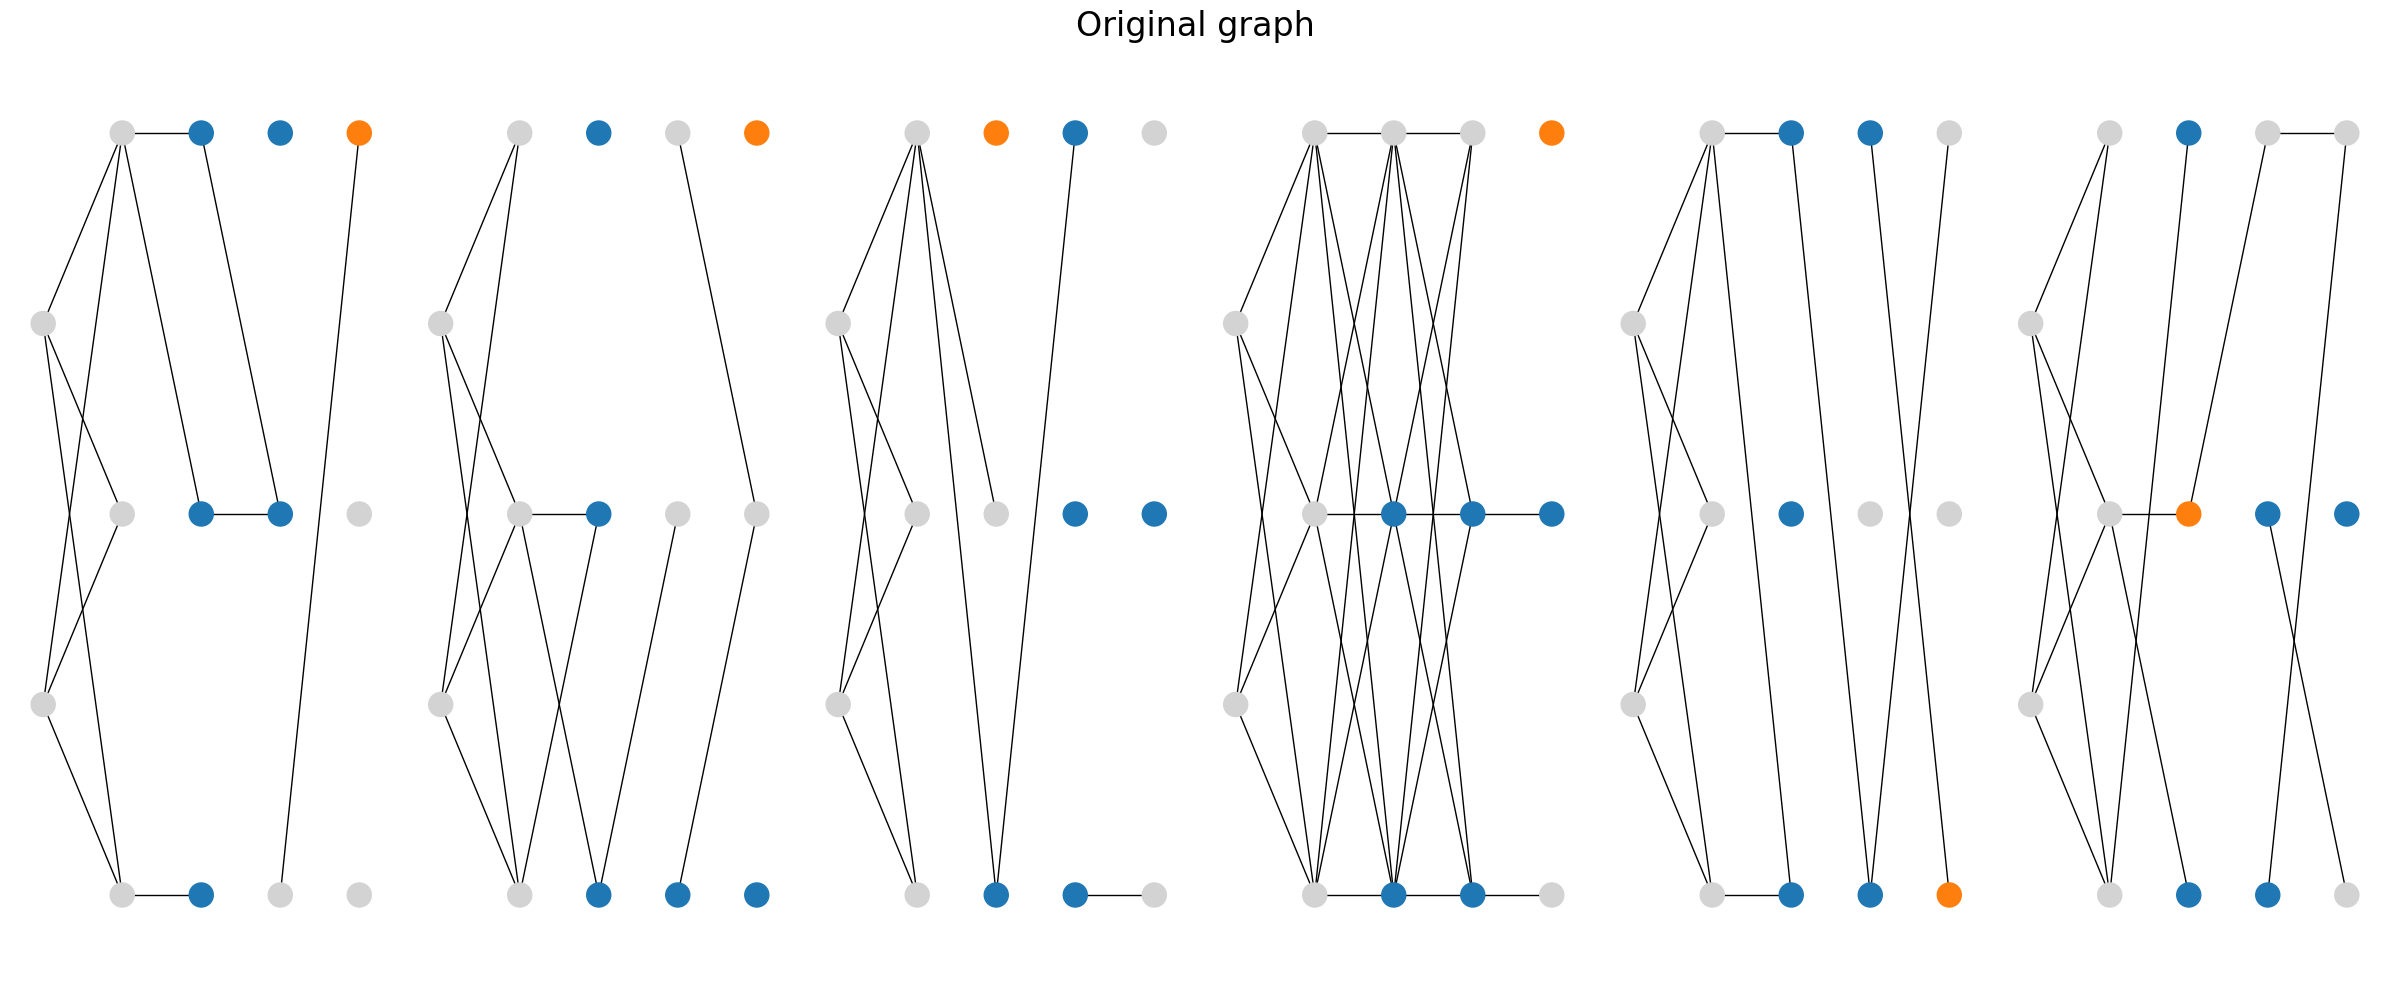

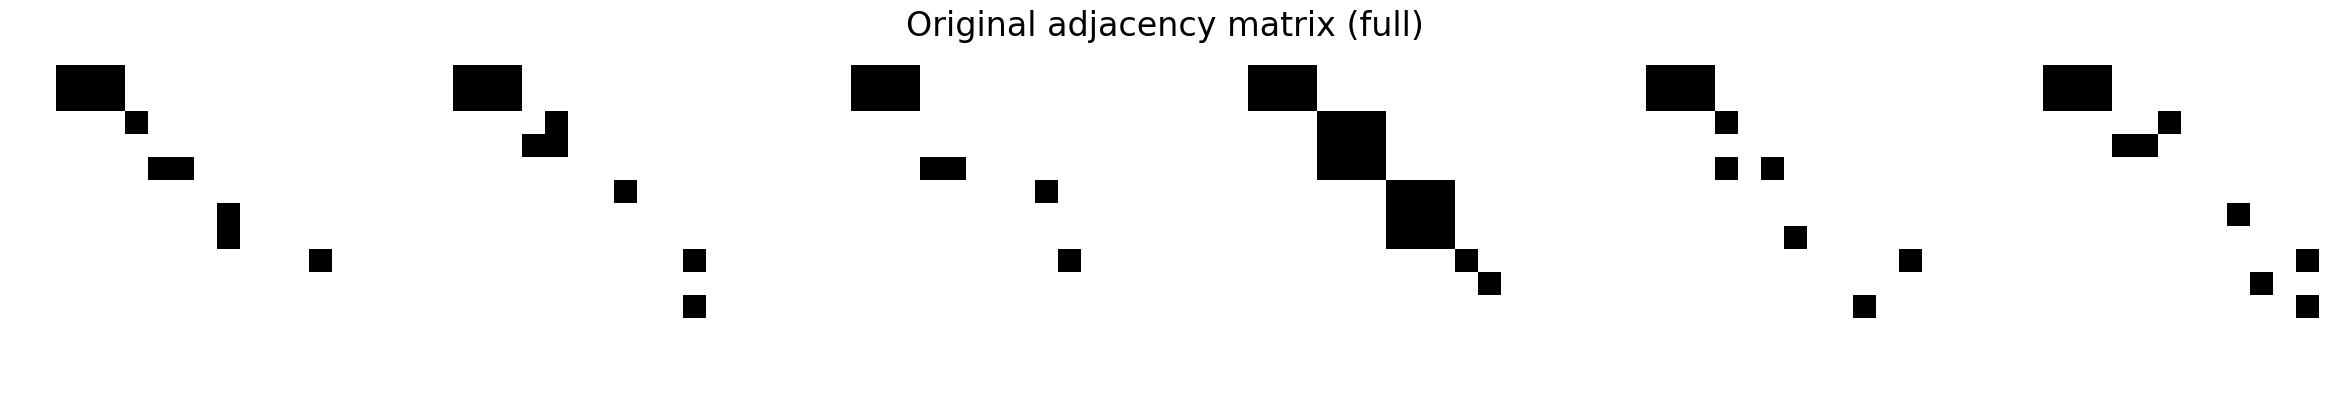

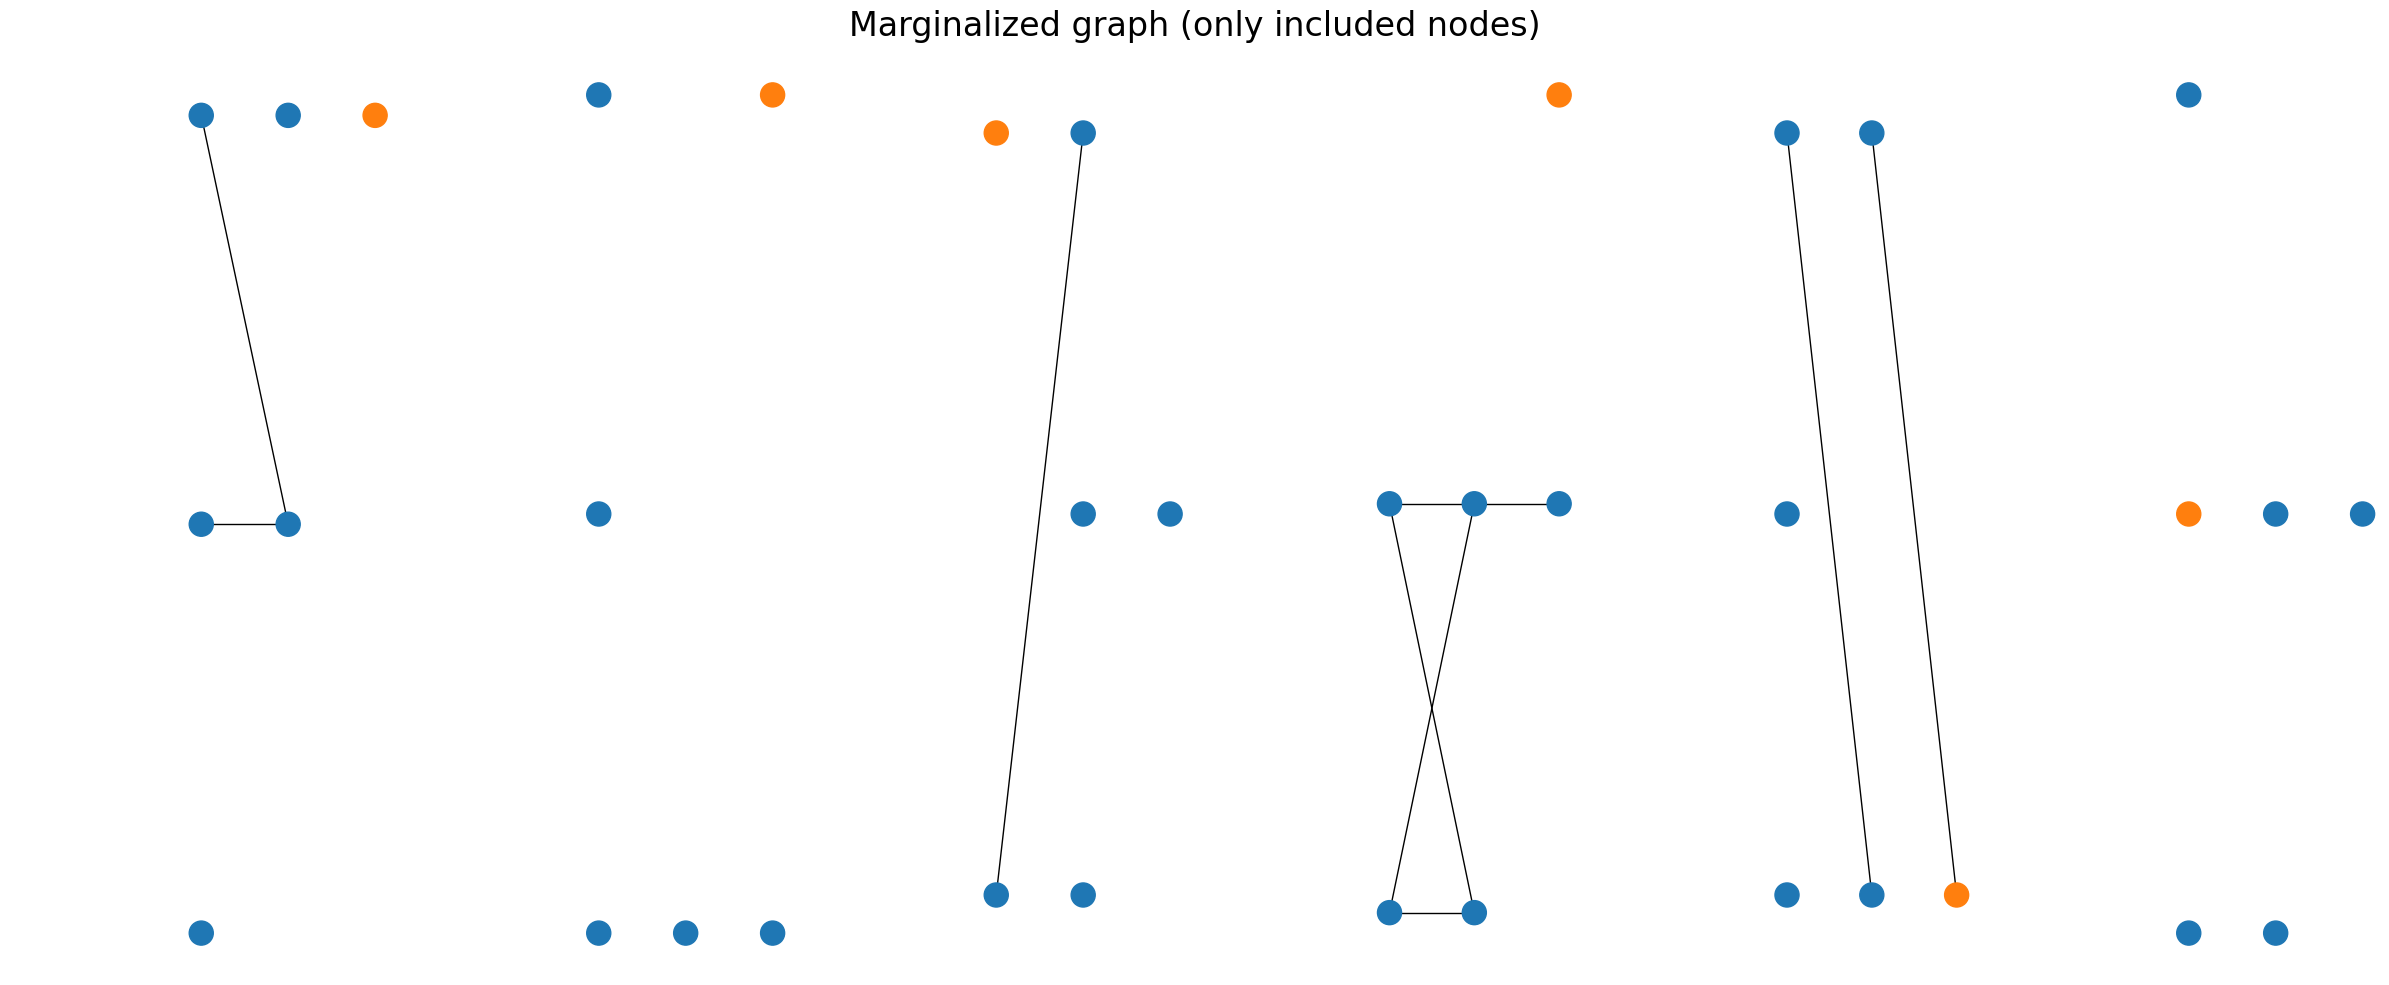

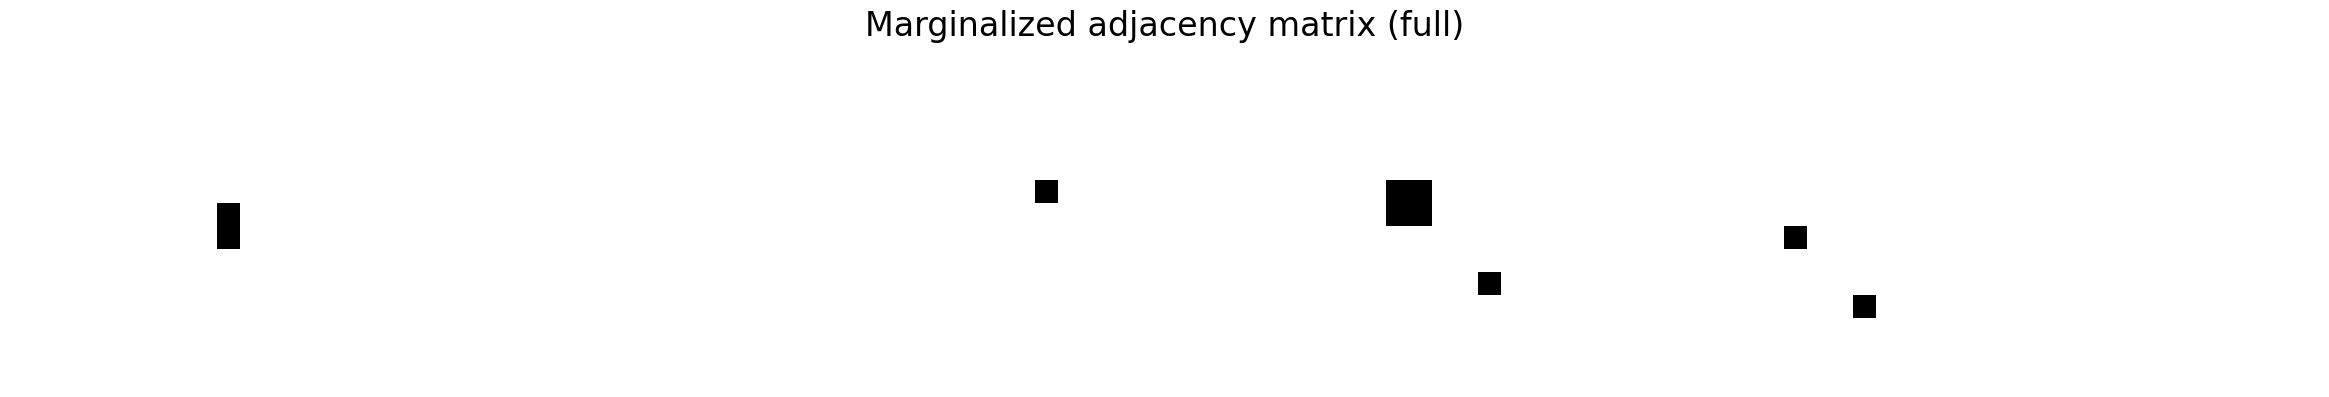

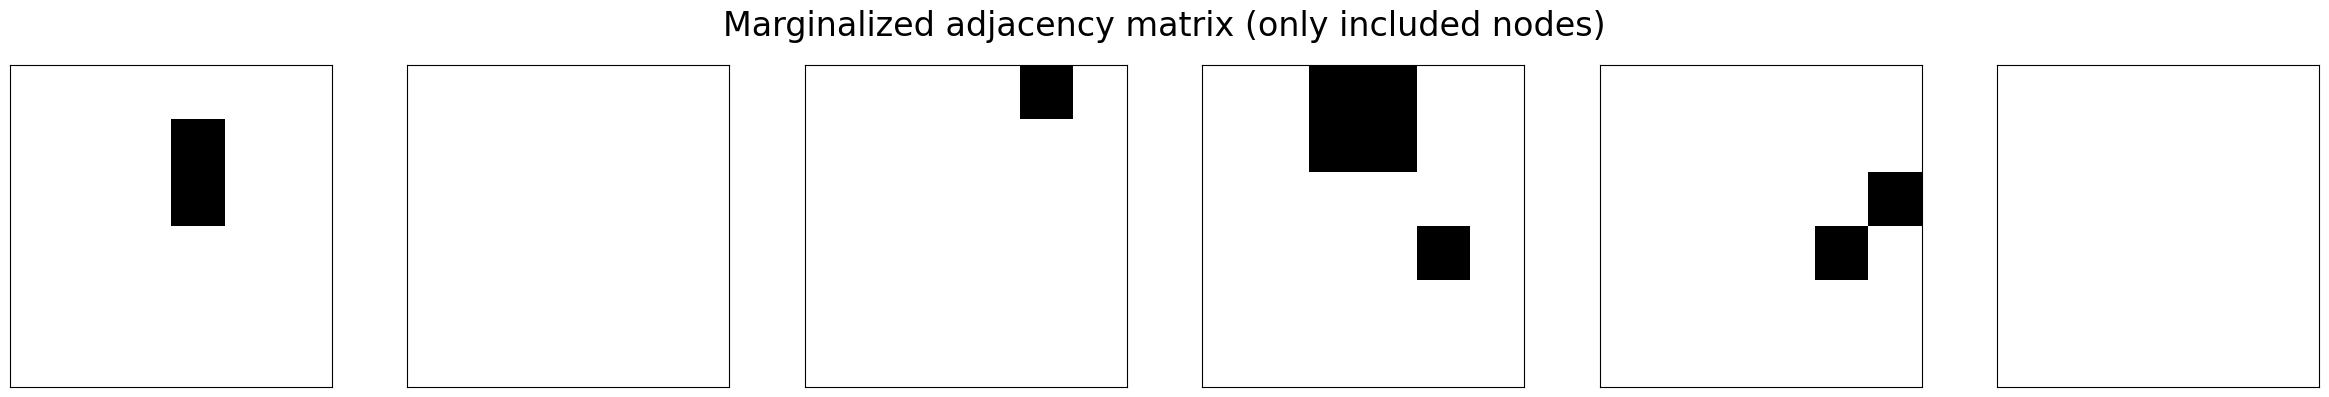

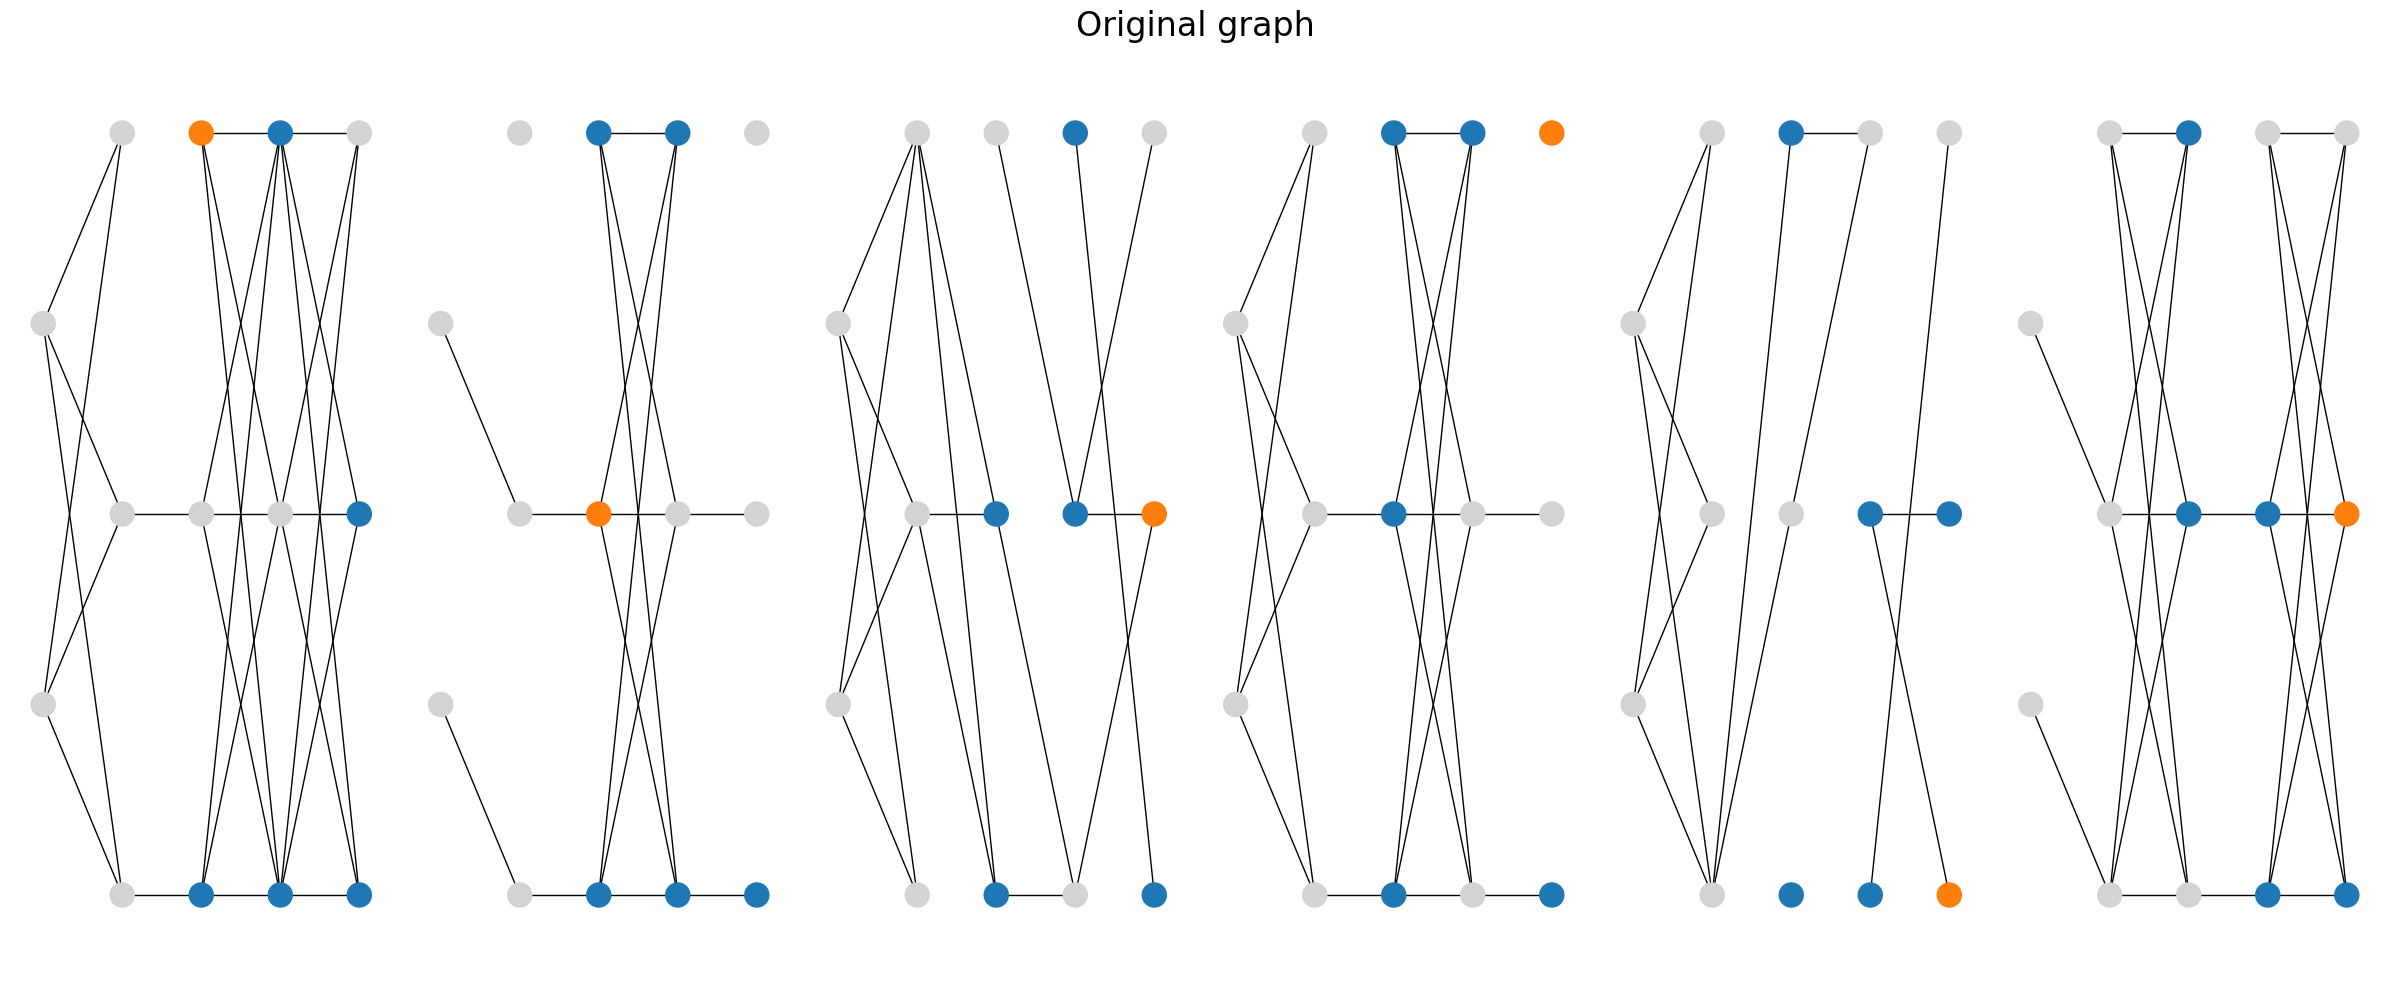

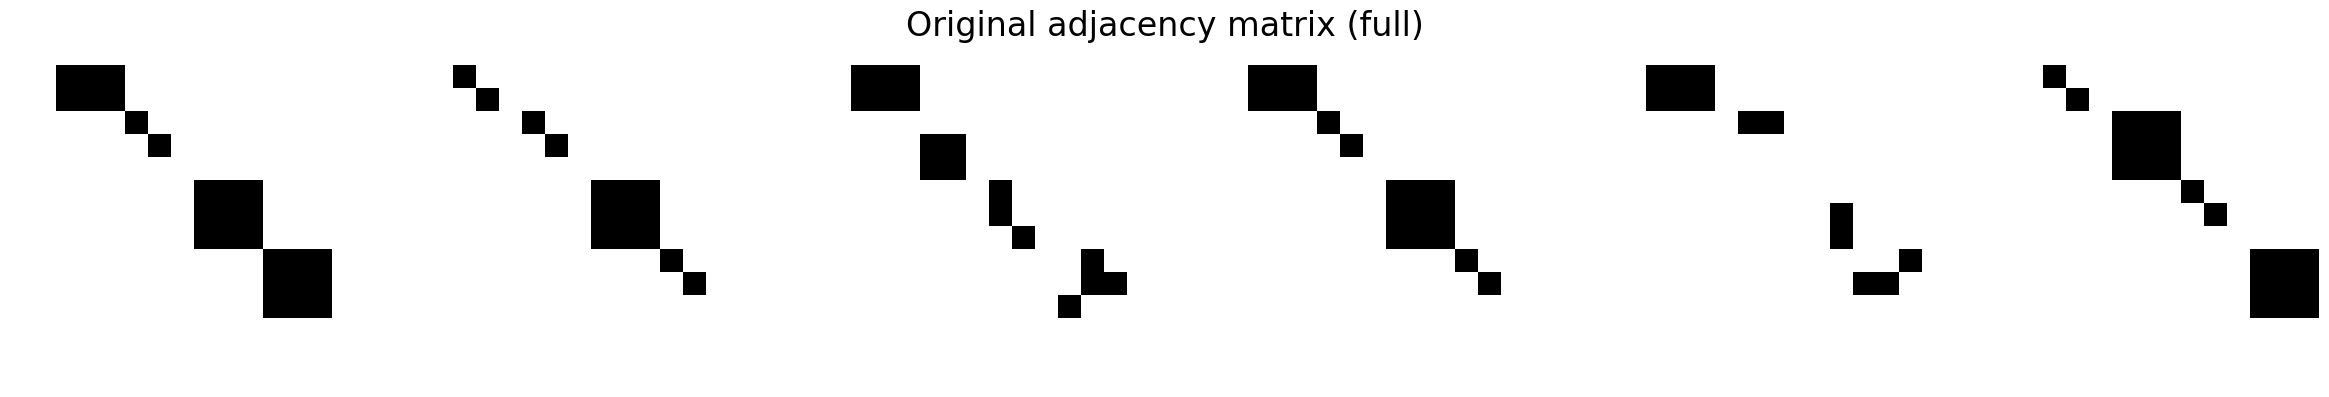

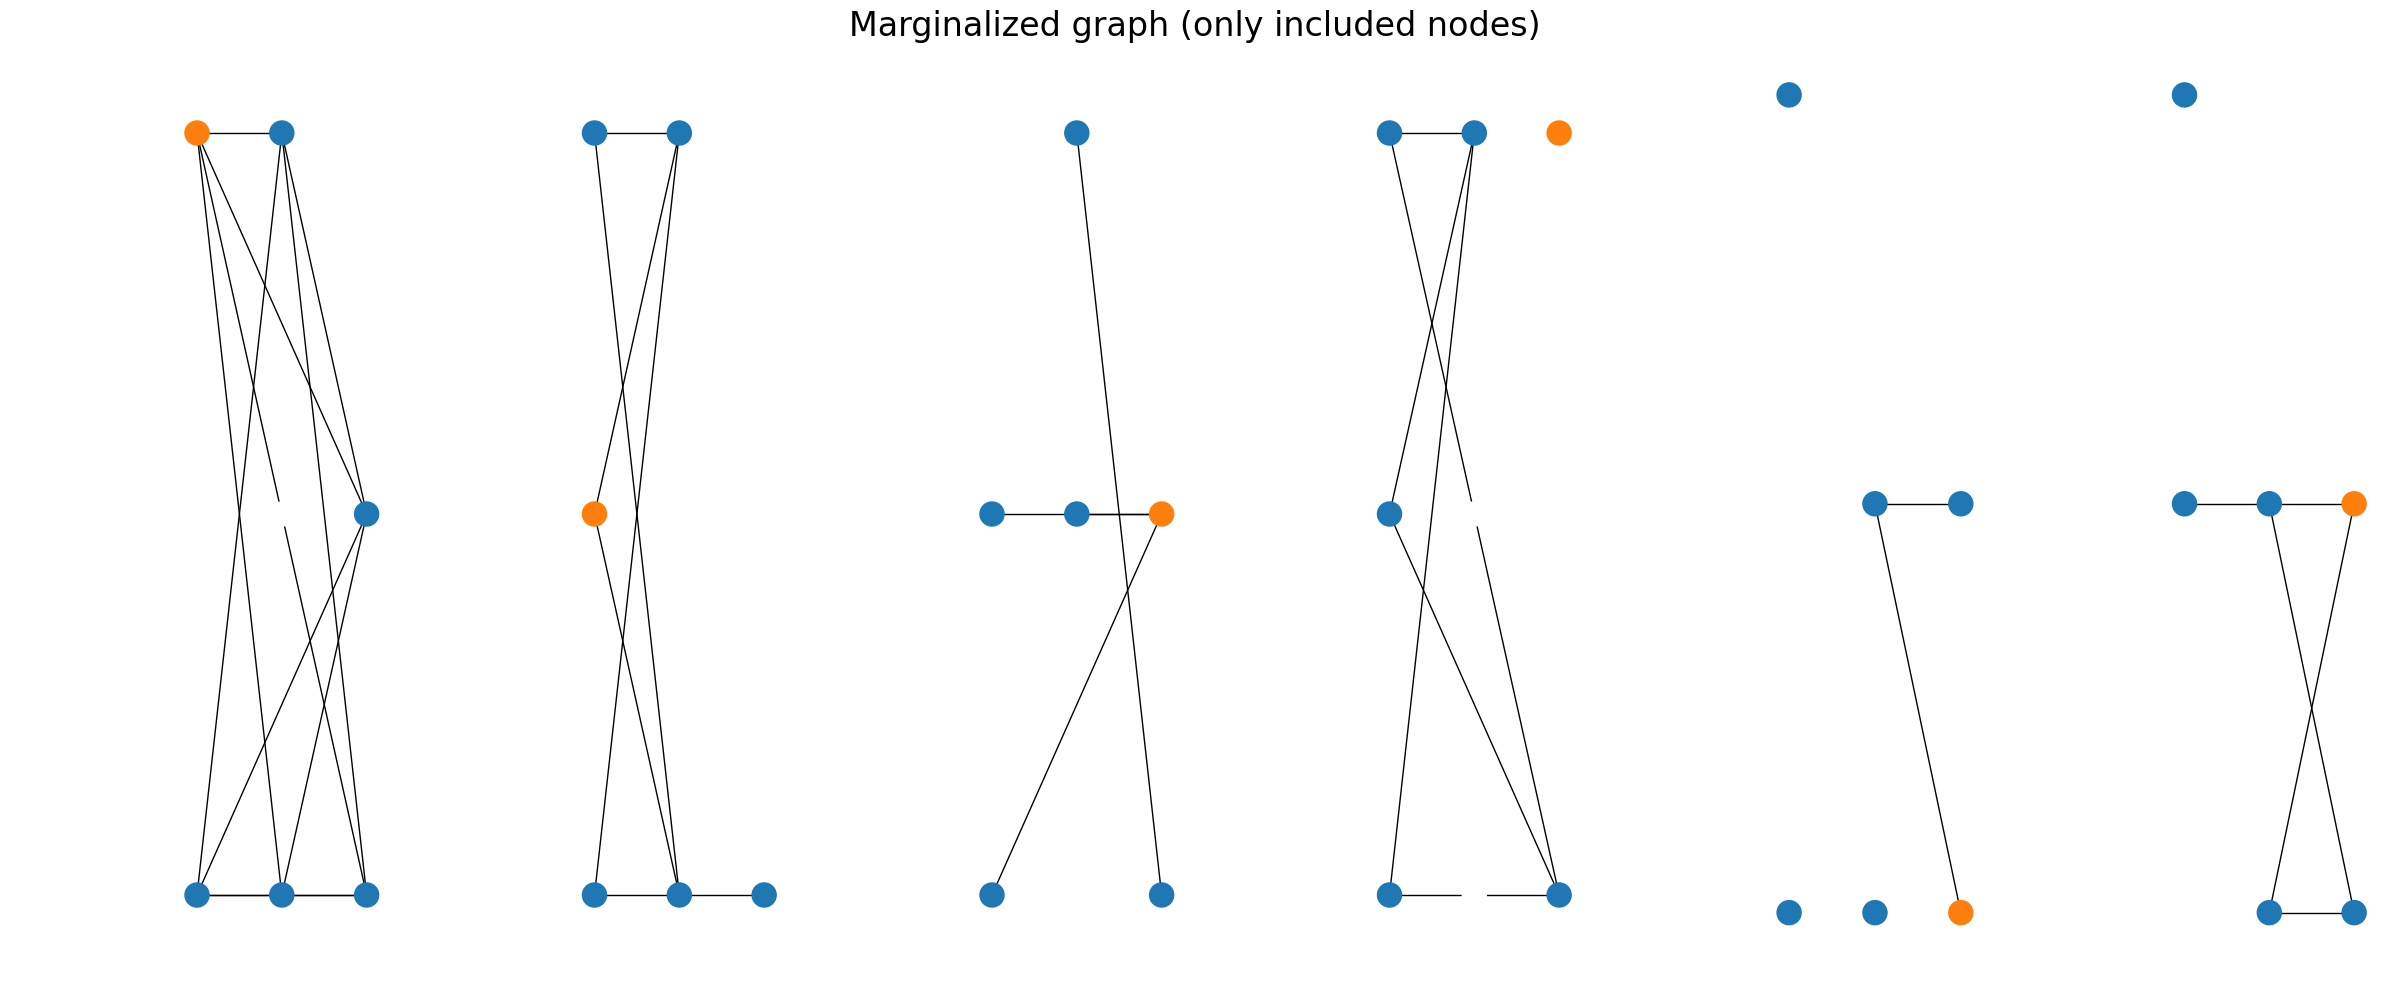

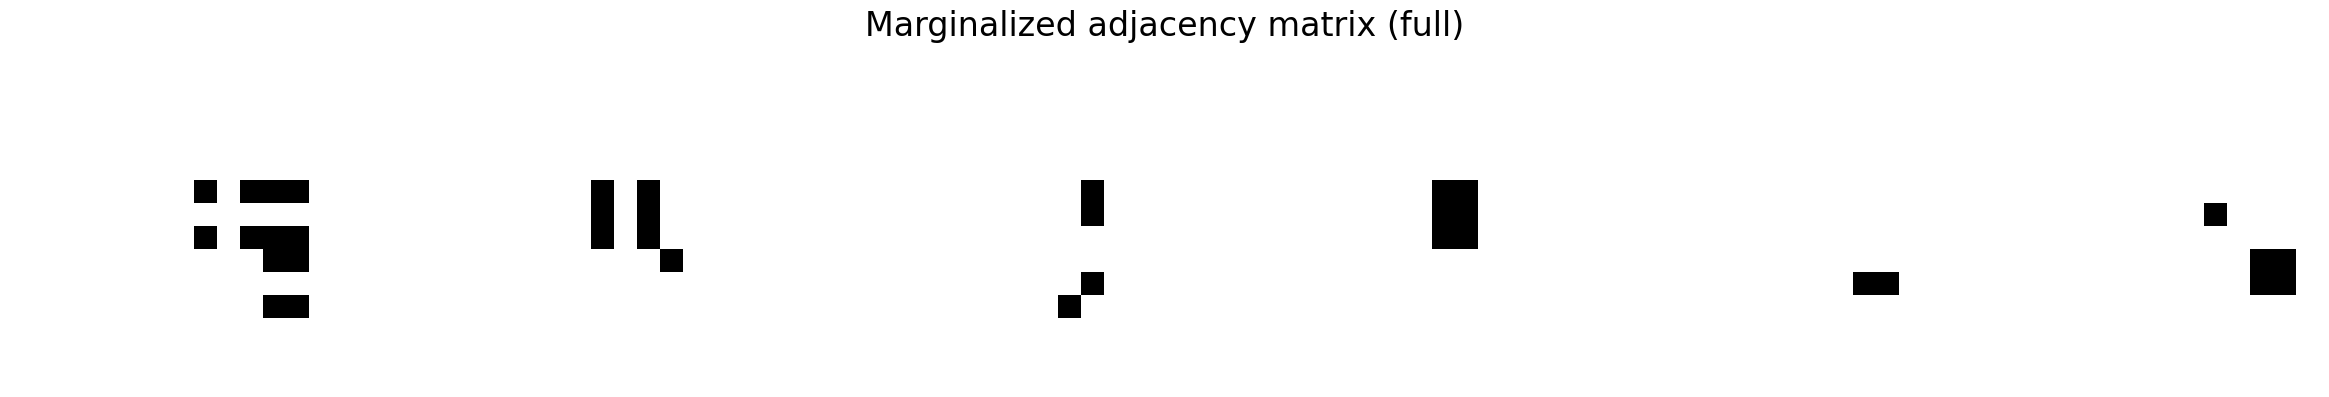

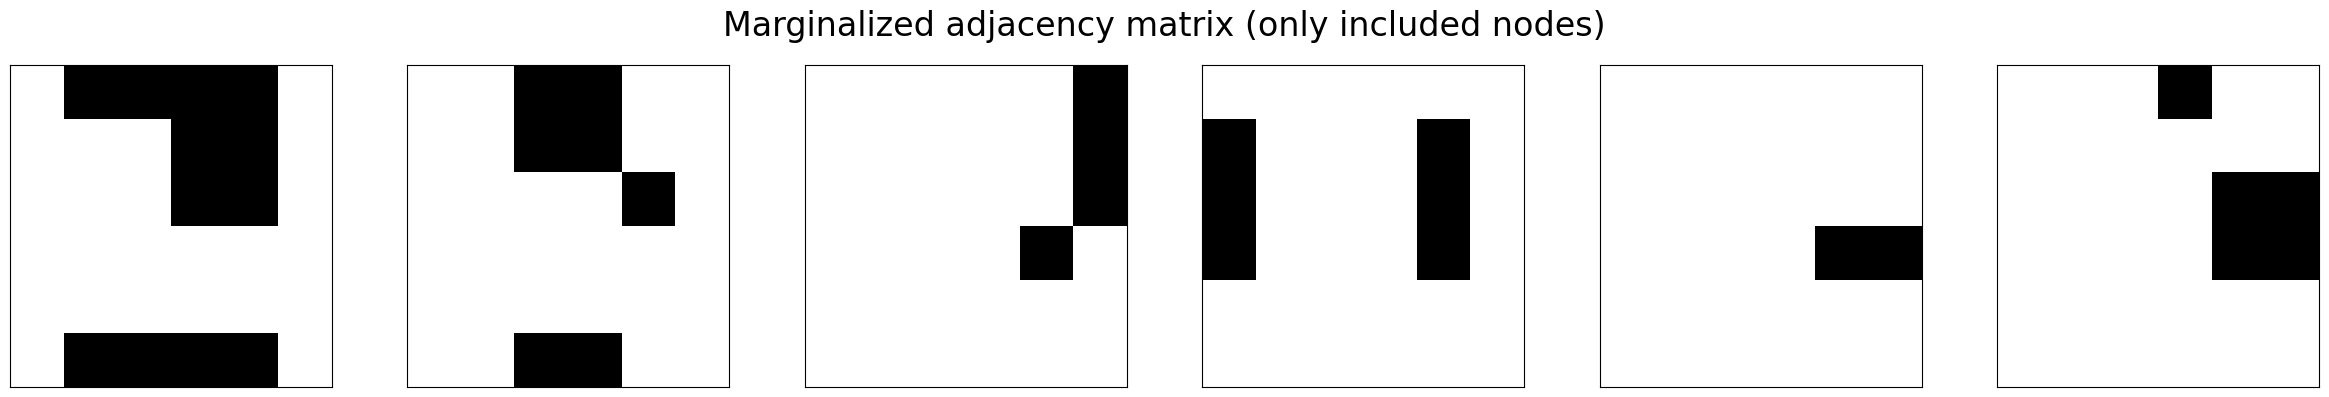

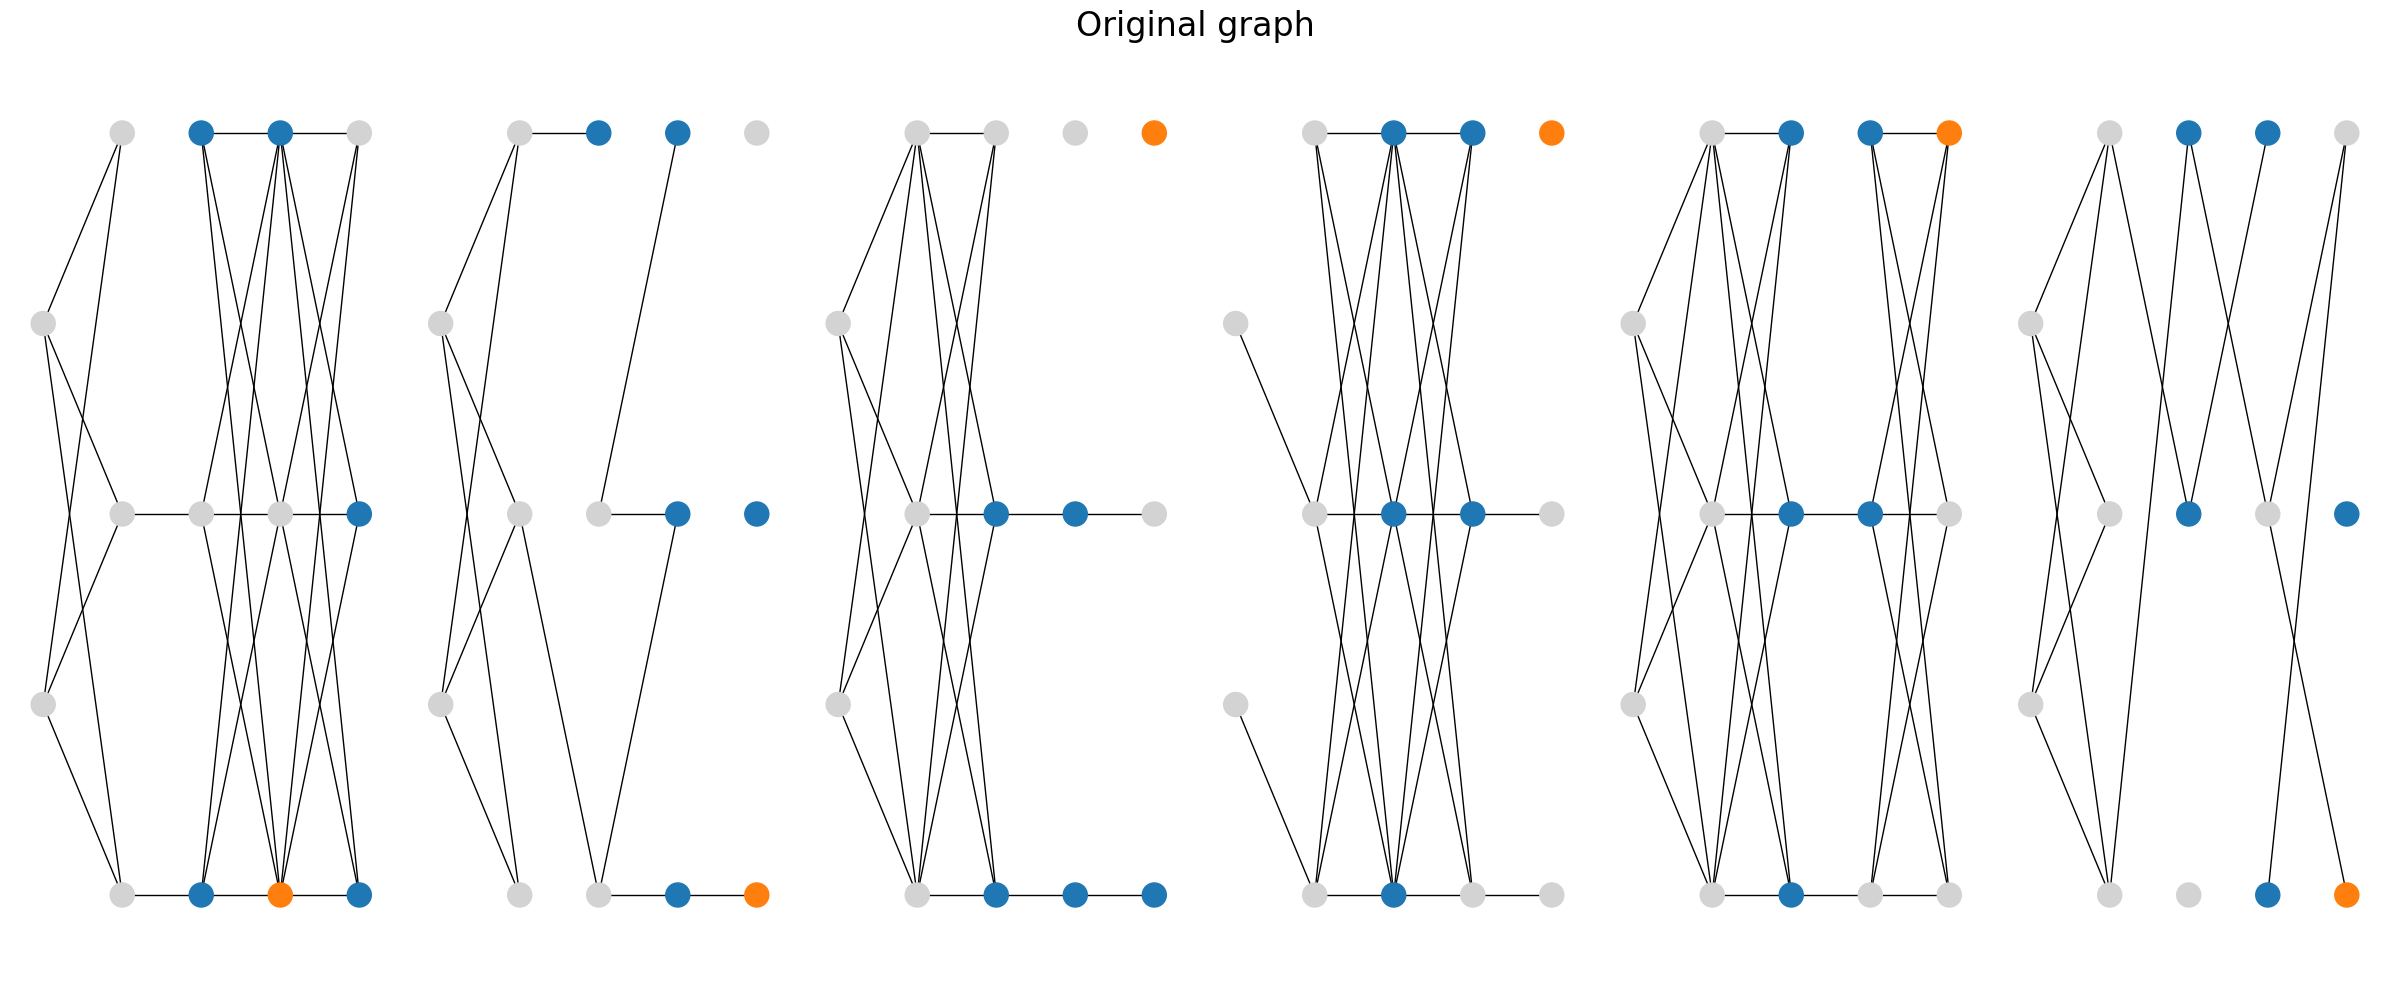

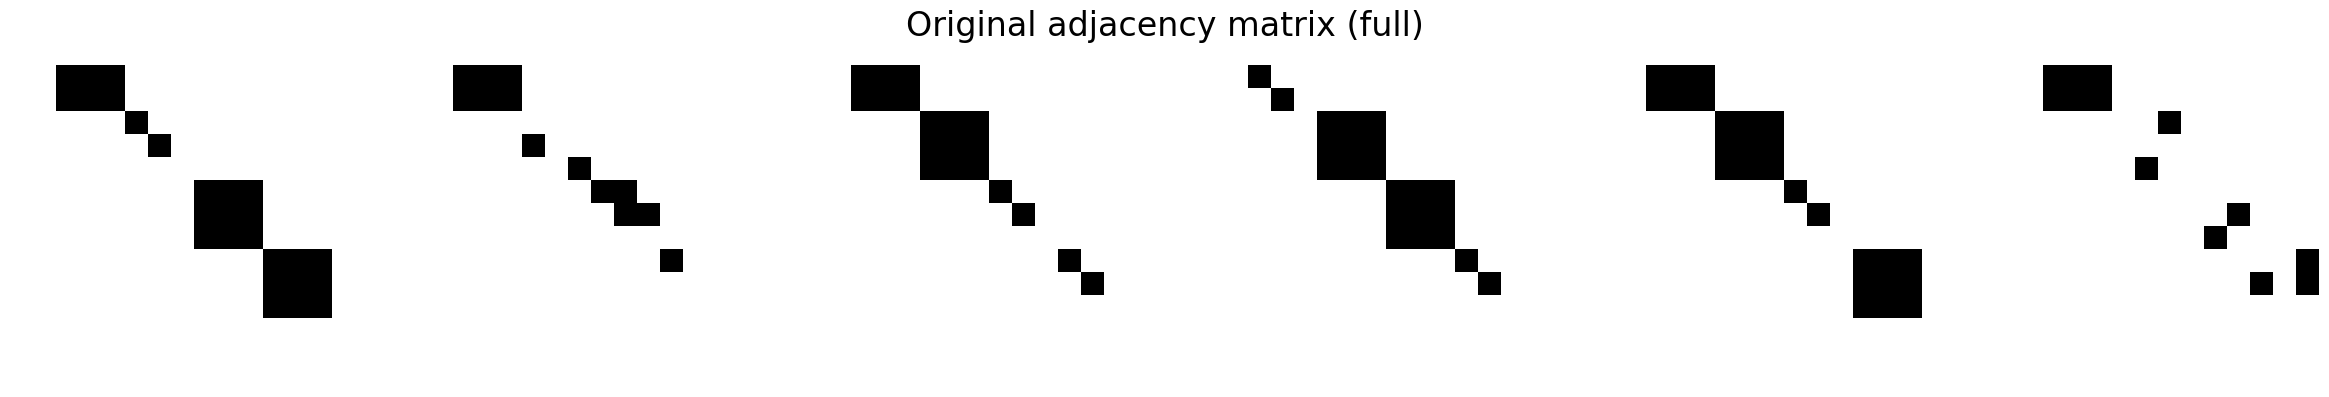

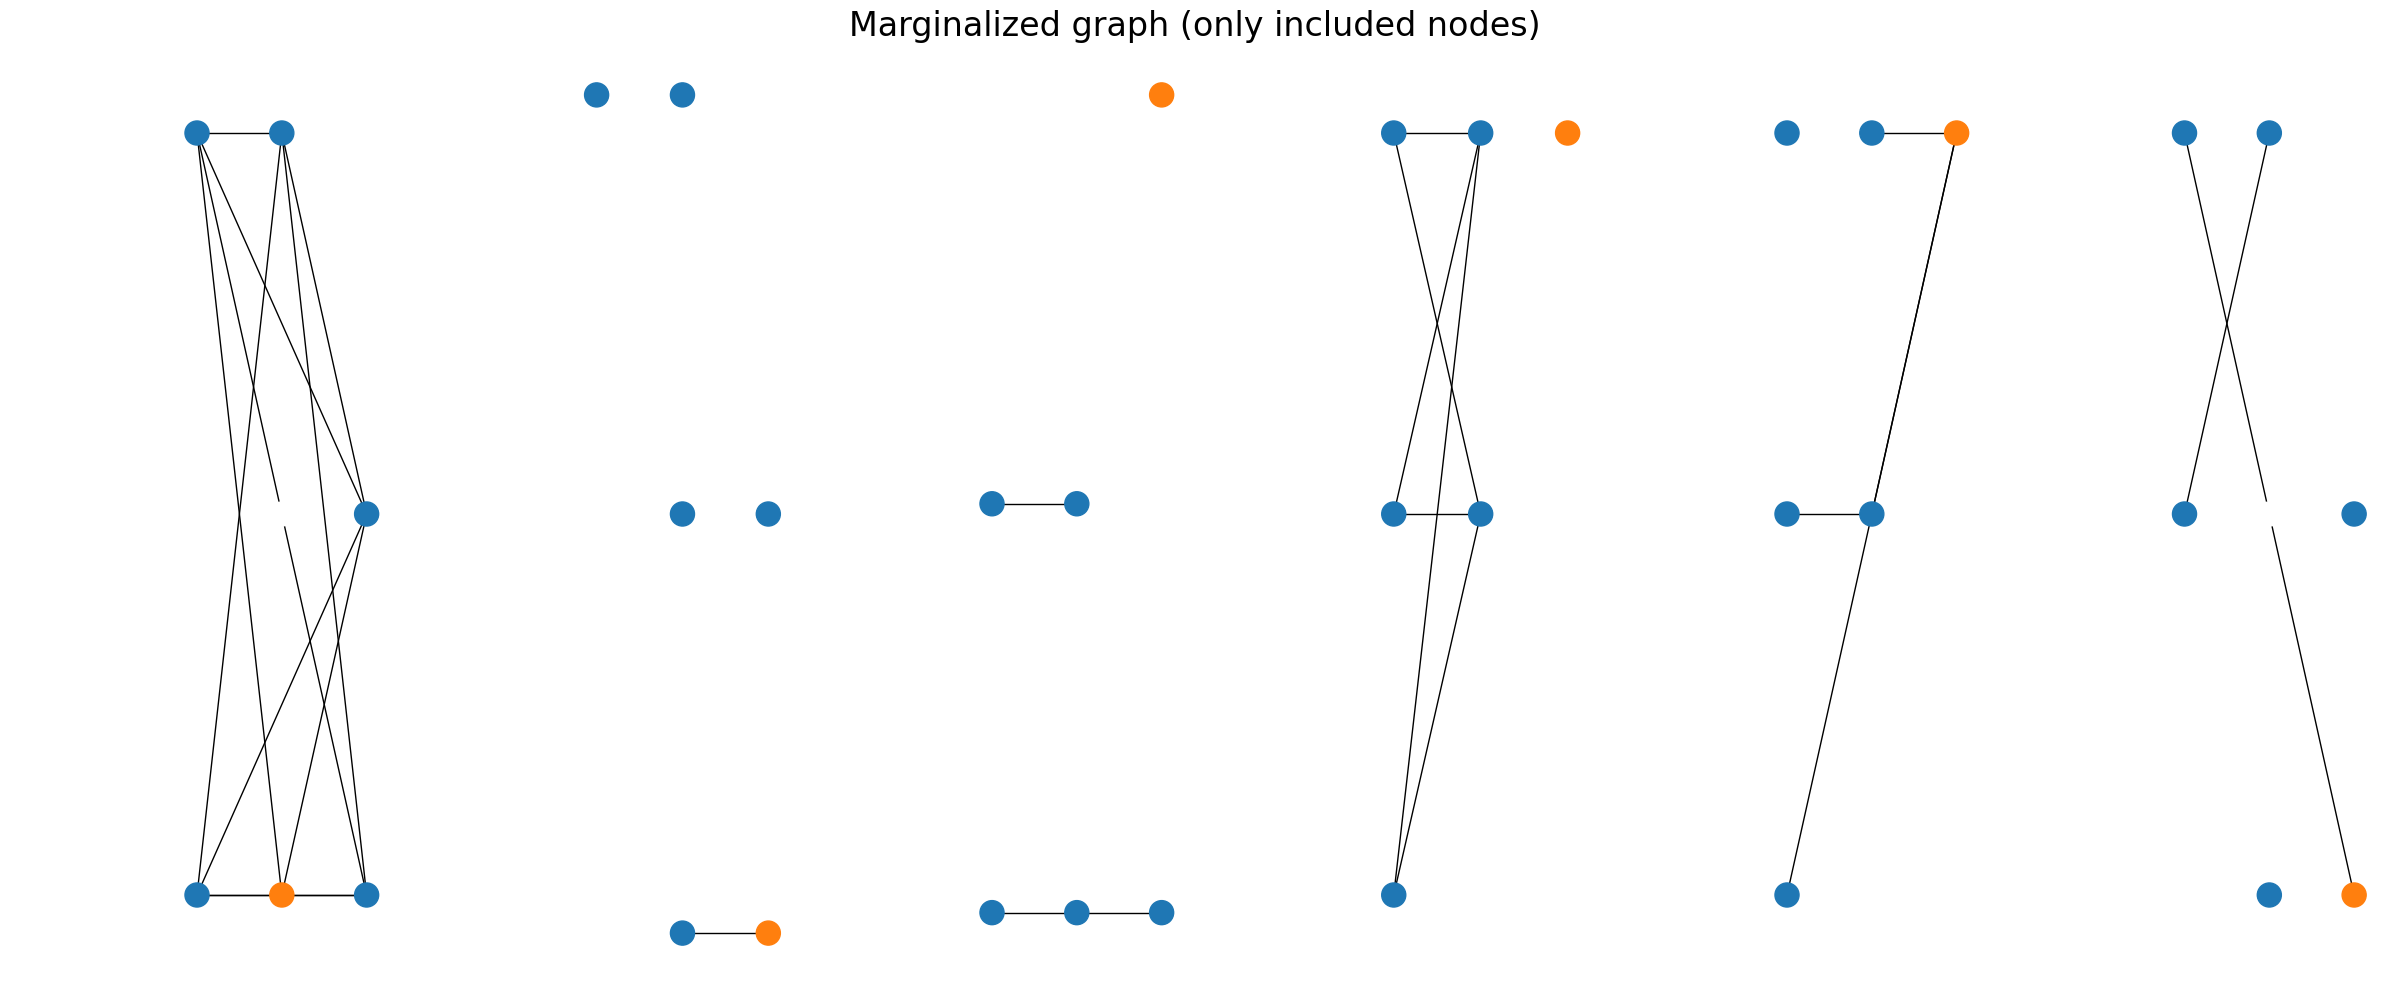

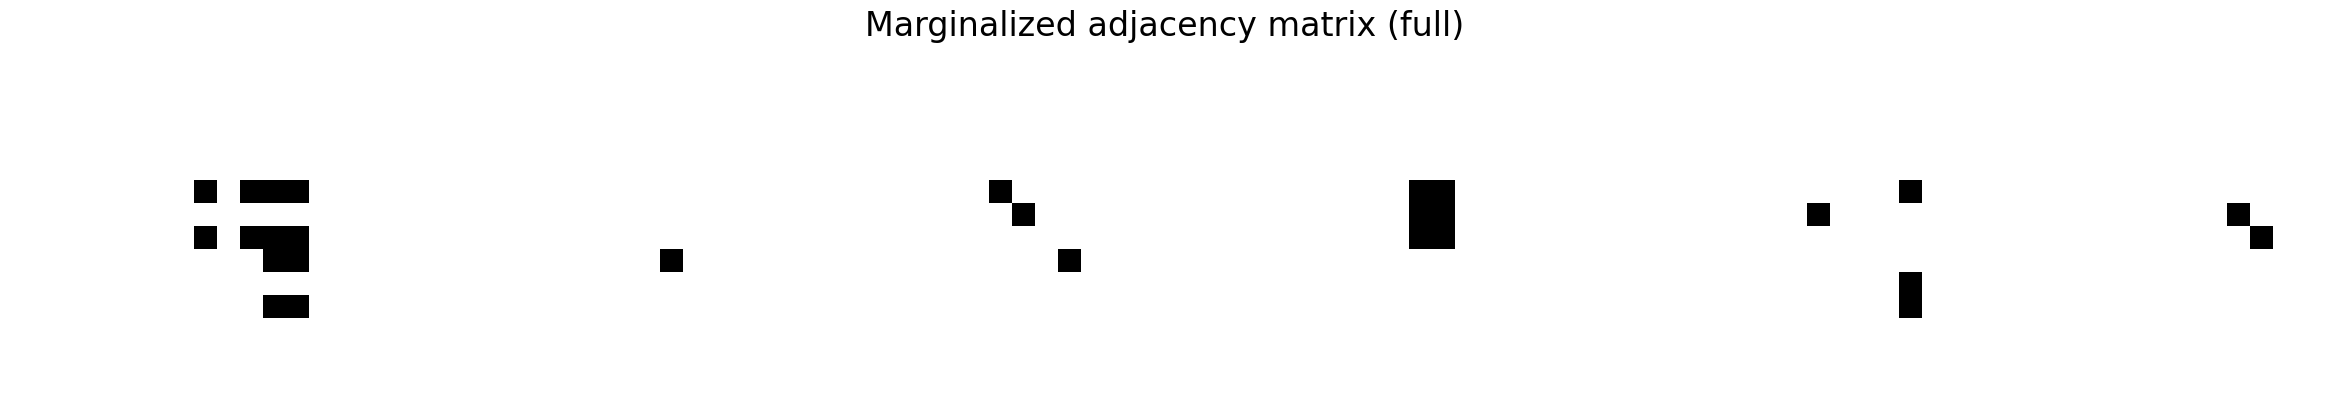

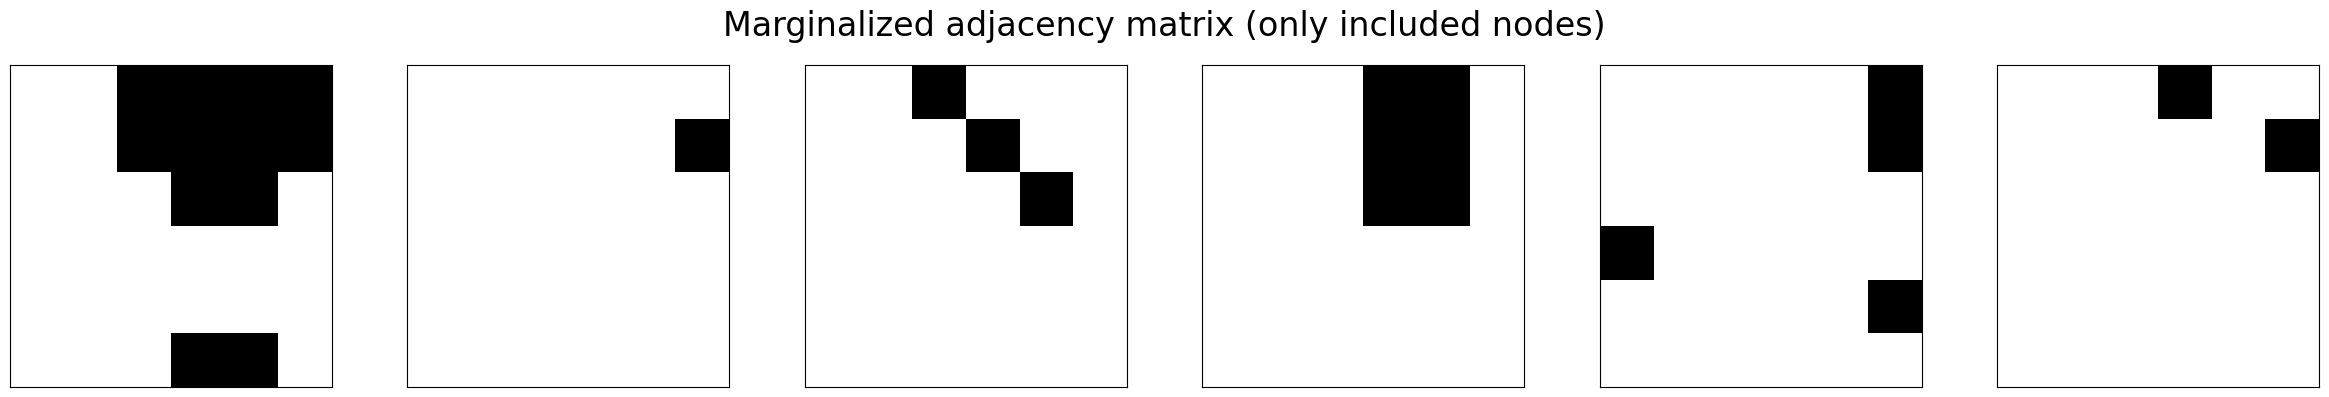

In [18]:
n_cols = 6
cmap = ListedColormap(['white', 'black'])

for j, i in enumerate(range(0, len(adjs), n_cols)):
    idx_slice = slice(i, i+n_cols)

    draw_scms(graphs[idx_slice], suptitle='Original graph',
        edge_alpha = 1.,
    )
    imshow(adjs[idx_slice], cmap = cmap, suptitle='Original adjacency matrix (full)')

    draw_scms(graphs_marg[idx_slice], suptitle='Marginalized graph (only included nodes)',
        edge_alpha = 1.,
        nodelists = nodelists[idx_slice],
    )
    imshow(adjs_marg[idx_slice], cmap = cmap, suptitle='Marginalized adjacency matrix (full)')
    adj_marg_sel = [adj_marg[np.ix_(nodelist, nodelist)] for adj_marg, nodelist in zip(adjs_marg[idx_slice], nodelists[idx_slice])]
    imshow(adj_marg_sel, cmap = cmap, turn_off_axis='only_border', suptitle='Marginalized adjacency matrix (only included nodes)')

    # if j > 0: break
    print('\n\n\n\n')
